In [1]:
## Make Imports 
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud, STOPWORDS 
from nltk.stem import WordNetLemmatizer
from IPython.core.display import HTML
from nltk.corpus import stopwords 
from collections import Counter
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
from plotly import tools
import IPython.display
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import warnings
import operator
import string 
import re 

## Environment Preparation
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
stopwords = stopwords.words("english")
punc = string.punctuation 
lem = WordNetLemmatizer()

## Load dataset
user_followers = pd.read_csv("../input/UserFollowers.csv")
kernels_tag_df = pd.read_csv("../input/KernelTags.csv")
messages = pd.read_csv("../input/ForumMessages.csv")
forums_df = pd.read_csv("../input/Forums.csv")
kernels_df = pd.read_csv("../input/Kernels.csv")
tags_df = pd.read_csv("../input/Tags.csv")
users = pd.read_csv("../input/Users.csv")

## function to clean the text
def clean_text(txt):    
    txt = txt.lower()
    txt = re.sub('<[^<]+?>', '', txt)
    txt = "".join(x for x in txt if x not in punc)
    words = txt.split()
    words = [wrd for wrd in words if wrd not in stopwords]
    words = [wrd for wrd in words if not wrd.startswith("http")]
    txt = " ".join(words)
    return txt

## function to generate ngrams
def ngrams(txt, n):
    txt = txt.split()
    output = []
    for i in range(len(txt)-n+1):
        output.append(" ".join(txt[i:i+n]))
    return output

## function to create bins 
def wordmap(val):
    if val < 10:
        return "0-10"
    elif val < 20:
        return "10-25"
    elif val < 50:
        return "25-50"
    elif val < 100:
        return "50-100"
    else:
        return "100+"

## main Analysis Function
def _analyze_profile(username):
    account_id = users[users["UserName"] == username]["Id"].iloc(0)[0]
    name = users[users["UserName"] == username]["DisplayName"].iloc(0)[0]

    mydf = messages[messages["PostUserId"] == account_id]
    mydf['PostDate'] = pd.to_datetime(mydf["PostDate"])
    mydf["weekday"] = mydf["PostDate"].dt.weekday
    mydf["monthday"] = mydf["PostDate"].dt.day
    mydf["hour"] = mydf["PostDate"].dt.hour
    mydf["clean_message"] = mydf["Message"].fillna("").apply(lambda x : clean_text(x))
    mydf["word_len"] = mydf["clean_message"].apply(lambda x : len(x.split()))
    mydf["char_len"] = mydf["clean_message"].apply(lambda x : len(x.replace(" ","")))

    text = " ".join(mydf["clean_message"].dropna())
    unigrams = Counter(ngrams(text, 1))
    bigrams = Counter(ngrams(text, 2))
    unigrams_d = dict(unigrams)
    bigrams_d = dict(bigrams)

    mydf["word_len_bin"] = mydf["word_len"].apply(wordmap)
    mydf["char_len_bin"] = mydf["char_len"].apply(wordmap)

    mydf['Date'] = mydf['PostDate'].dt.date
    mydf['month'] = mydf['PostDate'].dt.month
    dateComments = mydf['Date'].value_counts().to_frame().reset_index().sort_values("index")

    mytags = []
    forumIDs = list(mydf['ForumTopicId'].values)
    for forum_id in forumIDs:
        try:
            kernel_id = kernels_df[kernels_df["ForumTopicId"] == forum_id]['Id'].iloc(0)[0]
            taglist = list(kernels_tag_df[kernels_tag_df["KernelId"] == kernel_id]["TagId"].values)
            mytags.extend(tags_df[tags_df["Id"].isin(taglist)]['Name'].values)
        except Exception as E:
            pass
    
    metrics = {"mytags" : mytags, "unigrams" : unigrams, "unigrams_d" : unigrams_d,
               "bigrams" : bigrams, "bigrams_d" : bigrams_d, "dateComments" : dateComments, 
               "name" : name, "account_id" : account_id}
    return mydf, metrics

## Main Visualization Function
def _prepare(mydf, metrics):
    mytags = metrics["mytags"]
    unigrams = metrics["unigrams"]
    bigrams = metrics["bigrams"]
    bigrams_d = metrics["bigrams_d"]
    unigrams_d = metrics["unigrams_d"]
    dateComments = metrics["dateComments"] 
    account_id = metrics["account_id"]
    name = metrics["name"]

    mpp = {0 : "Mon", 1: "Tue", 2: "Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
    mydf["word_density"] = mydf["char_len"] / (1+mydf["word_len"])
    mydf["word_density"] = mydf["word_density"].apply(lambda x : round(x,2))

    daymp = {}
    lst = mydf["weekday"].value_counts().to_frame().reset_index()
    for l,day in lst.iterrows():
        daymp[day["index"]] = day["weekday"]
    sorted_x = sorted(daymp.items(), key=operator.itemgetter(1), reverse = True)
    
    # insights_t = {
    #     "Total Discussions" : len(mydf),
    #     "Average Discussions Per Day" : int(np.mean(np.array(dateComments["Date"].values))),
    #     "Average Discussions Per Month" : int(np.mean(mydf["month"].value_counts().values)),
    #     "Maximum Discussions on Single Day" : int(np.max(np.array(dateComments["Date"].values))),
    #     "Maximum Discussions Date" : str(dateComments[dateComments["Date"] == np.max(np.array(dateComments["Date"].values))]["index"].iloc(0)[0]),
    #     "Most Discussions WeekDay" : mpp[sorted_x[0][0]],
    #     "Least Discussions WeekDay" : mpp[sorted_x[-1][0]],
    #     "Average Words Per Discussions" : int(np.mean(mydf["word_len"])),
    #     "Average Characters Per Discussions" : int(np.mean(mydf["char_len"])),
    #     "Average Word Density Per Discussions" : round(np.mean(mydf["word_density"]),2),
    #     "Top KeyWord Used" : unigrams.most_common()[0][0],
    #     "Top Tag Followed" : Counter(mytags).most_common(1)[0][0],
    #     "Total Discussions" : len(mydf),
    #    "Average Discussions Per Day" : int(np.mean(np.array(dateComments["Date"].values))),
    #    "Average Discussions Per Month" : int(np.mean(mydf["month"].value_counts().values)),
    #     "Maximum Discussions on Single Day" : int(np.max(np.array(dateComments["Date"].values))),
    #     "Maximum Discussions Date" : str(dateComments[dateComments["Date"] == np.max(np.array(dateComments["Date"].values))]["index"].iloc(0)[0]),
    #    "Most Discussions WeekDay" : mpp[sorted_x[0][0]],
    #    "Least Discussions WeekDay" : mpp[sorted_x[-1][0]],
    #    "Average Words Per Discussions" : int(np.mean(mydf["word_len"])),
    #    "Average Characters Per Discussions" : int(np.mean(mydf["char_len"])),
    #    "Average Word Density Per Discussions" : round(np.mean(mydf["word_density"]),2),
    #    "Top KeyWord Used" : unigrams.most_common()[0][0],
    #    "Top Tag Followed" : Counter(mytags).most_common(1)[0][0],
    #}
    
    insights = {
        "Total Discussions" : len(mydf),
        "Average Discussions Per Day" : int(np.mean(np.array(dateComments["Date"].values))),
        "Average Discussions Per Month" : int(np.mean(mydf["month"].value_counts().values)),
        "Maximum Discussions on Single Day" : int(np.max(np.array(dateComments["Date"].values))),
        "Maximum Discussions Date" : str(dateComments[dateComments["Date"] == np.max(np.array(dateComments["Date"].values))]["index"].iloc(0)[0]),
        "Most Discussions WeekDay" : mpp[sorted_x[0][0]],
        "Least Discussions WeekDay" : mpp[sorted_x[-1][0]],
        "Average Words Per Discussions" : int(np.mean(mydf["word_len"])),
        "Average Characters Per Discussions" : int(np.mean(mydf["char_len"])),
        "Average Word Density Per Discussions" : round(np.mean(mydf["word_density"]),2),
        "Top KeyWord Used" : unigrams.most_common()[0][0],
        "Top Tag Followed" : Counter(mytags).most_common(1)[0][0],
    }

    tabs1 = list(insights.keys())
    tabvals1 = list(insights.values())
    tr9 = go.Table(header=dict(values=['Metric', 'Value'], line = dict(color='#7D7F80'), fill = dict(color='#a1c3d1'), align = ['left'] * 2),
                     cells=dict(values=[tabs1, tabvals1], line = dict(color='#7D7F80'), fill = dict(color='#EDFAFF'), align = ['left'] * 2))

    layout = dict(title="Report Summary : " + name, height=500)
    data = [tr9]
    fig = dict(data=data, layout=layout)
    iplot(fig)

    lst = unigrams.most_common(15)
    tr1 = go.Bar(y= [c[0] for c in lst][::-1], x= [c[1] for c in lst][::-1], orientation="h") 
    lst = bigrams.most_common(15)
    tr2 = go.Bar(y= [c[0] for c in lst][::-1], x= [c[1] for c in lst][::-1], orientation="h") 

    dvals = [daymp[0], daymp[1], daymp[2], daymp[3], daymp[4], daymp[5], daymp[6]]
    tr3 = go.Bar(x= ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], y= dvals, marker=dict(color="#c7a6ea")) 
    lst = mydf["monthday"].value_counts()
    tr4 = go.Bar(x= lst.index, y= lst.values, marker=dict(color="#c7a6ea")) 

    lst = dict(mydf["word_len_bin"].value_counts())
   # xx = ["0-10", "10-25", "25-50", "50-100", "100+"]
    xx = ["0-10", "10-25", "25-50", "50-100"]
    yy = [lst[v] for v in xx]
    tr5 = go.Bar(x= xx, y= yy, marker=dict(color="#eaa5b8")) 
    lst = mydf["char_len_bin"].value_counts()
    yy = [lst[v] for v in xx]
    tr6 = go.Bar(x= xx, y= yy, marker=dict(color="#eaa5b8")) 

    lst = Counter(mytags).most_common(15)
    tr7 = go.Scatter(x=[c+3 for c in range(len(lst))], y = [c[1] for c in lst], text=[c[0] for c in lst], 
                     textposition='top right', textfont=dict(size=10), mode='markers+text', marker=dict(color="#42f4a4", size=25 ))

    fig = tools.make_subplots(rows=5, cols=2, vertical_spacing = 0.05, print_grid=False, specs = [[{"colspan" : 2},None], [{},{}], [{},{}], [{"colspan" : 2},None], [{"colspan" : 2},None]], 
                             subplot_titles=["Discussions by Date", "Day of the Week - Discussion Activity", "Day of the Month - Discussion Activity",
                                             "Number of Words per Discussions", "Number of Characters used per Discussions", 
                                             "Top Kernel Tags Followed", "Followers Gained Since 2017" ])

    tr8 = go.Scatter(x = dateComments["index"], y = dateComments["Date"], mode="lines+markers", line=dict(color="orange", width=3))
    myfol = user_followers[user_followers["FollowingUserId"] == account_id]
    myfol["Date"] = pd.to_datetime(myfol["CreationDate"])
    tmp = myfol["Date"].value_counts().to_frame().reset_index().sort_values("index")
    tr10 = go.Scatter(x = tmp["index"], y = tmp["Date"], mode="lines+markers", line=dict(color="pink", width=3))

    fig.append_trace(tr8, 1, 1)
    fig.append_trace(tr3, 2, 1)
    fig.append_trace(tr4, 2, 2)
    fig.append_trace(tr5, 3, 1)
    fig.append_trace(tr6, 3, 2)
    fig.append_trace(tr7, 4, 1)
    fig.append_trace(tr10, 5, 1)

    fig['layout'].update(barmode='group', title = 'Kaggle Discussions Analysis Report: ' + name,
        titlefont=dict(size=22,color='#000'),                     
        margin=dict(t=100, b=100),
        paper_bgcolor='rgb(254, 247, 234)',
        plot_bgcolor='rgb(254, 247, 234)',
        height=1300,
        showlegend=False)
    iplot(fig);
    
## main wordcloud function
def _wc(mydf):
    wordcloud = WordCloud(max_font_size=40, max_words=12000, colormap='Dark2_r', random_state=42).generate(str(mydf['clean_message']))
    fig = plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.title("Top Used Words")
    plt.axis('off')
    plt.show()

## Function to generate Ngram Bubble Cloud
def _ngramCloud(bigrams, username):
    strr = "id,value,value1\nproject,\n"
    num = 1
    cnt = 1
    sizes =[9000,7500,6000,5000,4000,2500,2200,1900,1800,1860]
    for j, each in enumerate(bigrams.most_common(100)):
        val = each[1]
        strr += "project." +str(num)+"."+ str(each[0]) + "," + str(val) + "," + str(val) + "\n"
        if cnt % 2 == 0:
            num += 1
        cnt += 1
        if cnt == 100:
            break
    fout = open("flare"+username+".csv", "w")
    fout.write(strr)

    html_p1 = """<!DOCTYPE html><svg id='idd_"""+username+"""' width="760" height="760" font-family="sans-serif" font-size="10" text-anchor="middle"></svg>"""
    js_p1 = """require.config({paths: {d3: "https://d3js.org/d3.v4.min"}});
    require(["d3"], function(d3) {var svg=d3.select("#idd_"""+username+""""),width=+svg.attr("width"),height=+svg.attr("height"),format=d3.format(",d"),color=d3.scaleOrdinal(d3.schemeCategory20c);var pack=d3.pack().size([width,height]).padding(1.5);d3.csv("flare"""+username+""".csv",function(t){if(t.value=+t.value,t.value)return t},function(t,e){if(t)throw t;var n=d3.hierarchy({children:e}).sum(function(t){return t.value}).each(function(t){if(e=t.data.id){var e,n=e.lastIndexOf(".");t.id=e,t.package=e.slice(0,n),t.class=e.slice(n+1)}}),a=(d3.select("body").append("div").style("position","absolute").style("z-index","10").style("visibility","hidden").text("a"),svg.selectAll(".node").data(pack(n).leaves()).enter().append("g").attr("class","node").attr("transform",function(t){return"translate("+t.x+","+t.y+")"}));a.append("circle").attr("id",function(t){return t.id}).attr("r",function(t){return t.r}).style("fill",function(t){return color(t.package)}),a.append("clipPath").attr("id",function(t){return"clip-"+t.id}).append("use").attr("xlink:href",function(t){return"#"+t.id}),a.append("svg:title").text(function(t){return t.value}),a.append("text").attr("clip-path",function(t){return"url(#clip-"+t.id+")"}).selectAll("tspan").data(function(t){return t.class.split(/(?=[A-Z][^A-Z])/g)}).enter().append("tspan").attr("x",0).attr("y",function(t,e,n){return 13+10*(e-n.length/2-.5)}).text(function(t){return t})});});"""
    h = display(HTML(html_p1))
    j = IPython.display.Javascript(js_p1)
    IPython.display.display_javascript(j)

## master function to generate the complete report 
def _generate_report(username):
    mydf, metrics = _analyze_profile(username)
    _prepare(mydf, metrics)
    display(HTML("Top Ngrams Used"))
    _ngramCloud(metrics["bigrams"], username)
    _wc(mydf)

# Discussion activity analysis

Thanks to [Shivam Bansal's amazing kernel](https://www.kaggle.com/shivamb/analyse-your-kaggle-profile-framework), I was able to analyze my discussions activity on Kaggle.

To create your own report, fork this kernel, and invoke the _generate_report function with your username as the argument: 

**_generate_report("your_kaggle_user_name")**

# My discussion activity:


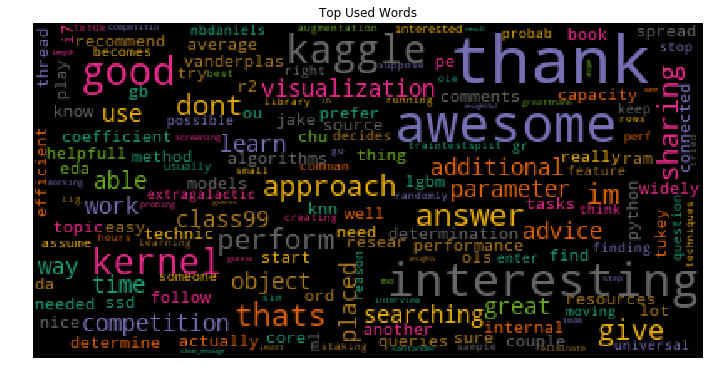

In [2]:
_generate_report("darbin")

To generate the analysis report for your kaggle profile, Follow these steps: 

1. Fork This Kernel (Also, upvote the kernel)
2. In the last cell, call _generate_report("your_kaggle_user_name")